# Weighted ECM clustering vs Traditional ECM clustering
### With IRIS (UCI dataset)

In [7]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot, plotting, calculate_non_specificity
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


D:\vtdo\projects\evclust\src\evclust\utils.py:1082: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


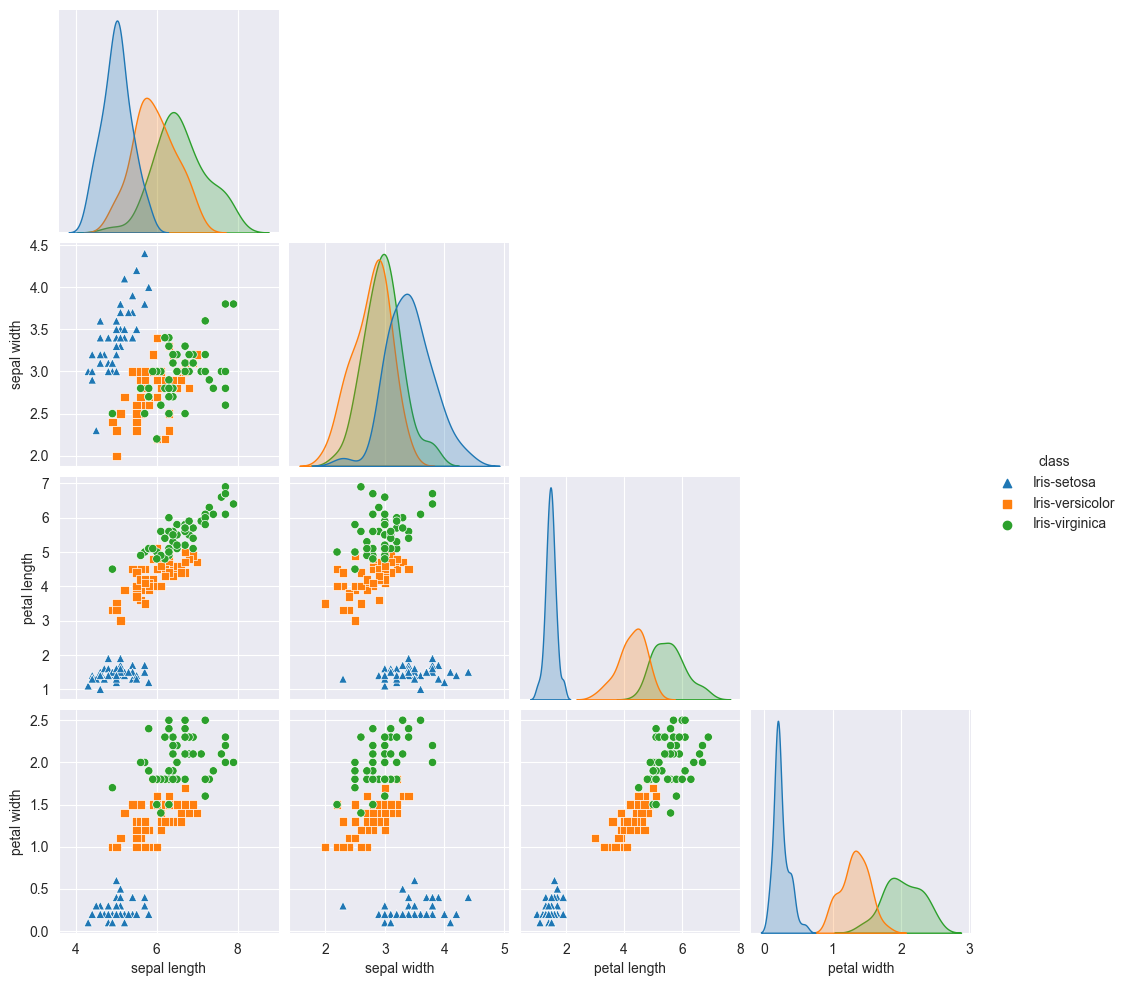

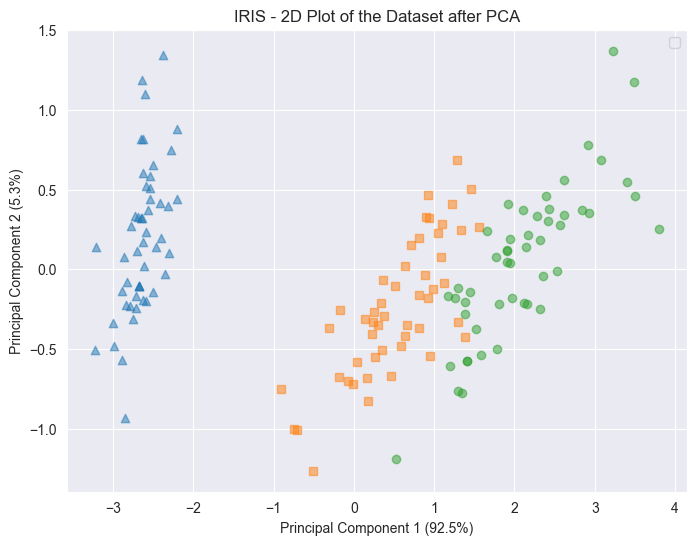

In [10]:
# fetch dataset - IRIS
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="IRIS", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[0.         3.49422779 3.49422779]
[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.500783480934679]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.4942277945449276]
[1.         3.49422779 3.49422779]
[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.500783480934679]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.4942277945449276]
[2.         3.49422779 3.49422779]
[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[3.         3.49422779 3.49422779]
[1, 3.54292165279678]
[2, 3.507929169010641]
[3, 3.5007834809346794]
[4, 3.4978458161927035]
[5, 3.4961142655269937]
[6, 3.4949799137722373]
[7, 3.494227794544927]
[4.         3.49422779 3.49422779]
[1, 3

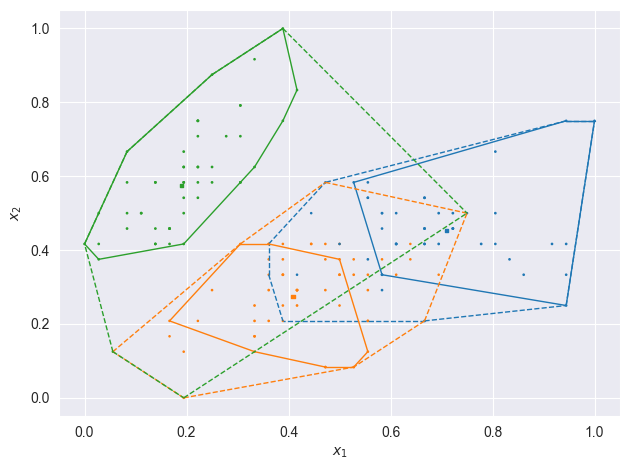

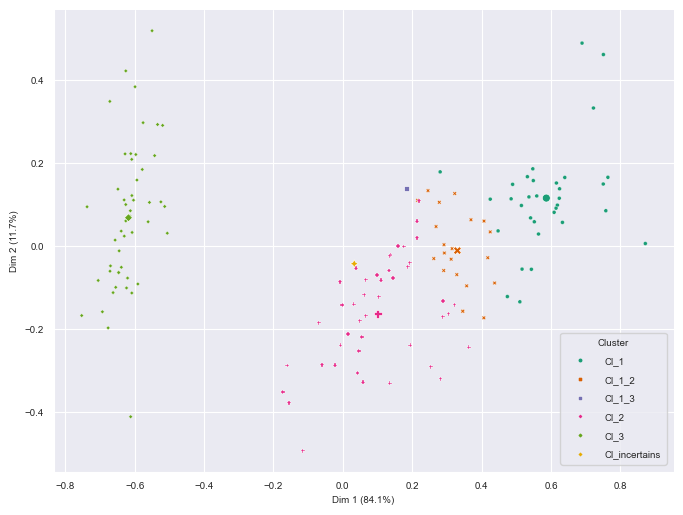

----------Traditional ECM----------
Jbest: 3.4942277945449267
Centers: 
 [[0.7104751  0.45380196 0.80923788 0.8621982 ]
 [0.40885519 0.27416984 0.55805394 0.51212921]
 [0.19075066 0.57579087 0.08402997 0.06124984]]
Adjusted Rand Index (ARI): 0.6770802856430762
Maximum Non-specificity value: 4.914589525998386
Minimum Non-specificity value: 0.07908539956422624
Average Non-specificity value: 1.2593004548624587
Average Normalized Non-specificity value: 0.7945301256587953


In [11]:
# Traditional ECM clustering
delta = np.sqrt(20)
model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, ntrials=10)

ev_plot(model, X=X)
ev_pcaplot(data=X, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = numeric_labels
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Traditional ECM----------")
print(f"Jbest: {model['crit']}")
print(f"Centers: \n {model['g']}")

print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Non-specificity
calculate_non_specificity(model)

## Weighted ECM (WECM)

In [28]:
# Weighted ECM clustering
model_list = np.array([])
for i in range(30):
    W = None
    g0 = None
    c = 3
    delta = np.sqrt(20)
    model = wecm(x=X, c=c, g0=g0, W=W, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=10)
    model_list = np.append(model_list, model)

# Get best 10 models with minimum values
num = 10
model_list = sorted(model_list, key=lambda x : x['crit'])
print([x['crit'] for x in model_list])
top_weights = [model['W'] for model in model_list[:num]]

# Get ARI values of top 10
true_labels = numeric_labels
predicted_labels_list = [np.argmax(model['betp'], axis=1) for model in model_list[:num]]
top_aris = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]
print(top_aris)
print(f"Average ARI: {np.mean(top_aris)}")

best_model = model_list[0]
print("----------Weighted ECM----------")
print(f"Jbest: {best_model['crit']}")
print(f"Centers: \n{best_model['g']}")
print(f"Weights: \n{best_model['W']}")
print(f"Adjusted Rand Index (ARI): {top_aris[0]}")
# 
# # Calculate Non-specificity
# calculate_non_specificity(model)
# 

Initial weights: 
 [[0.27779527 0.05877795 0.54476598 0.1186608 ]
 [0.16173615 0.5488379  0.24446255 0.0449634 ]
 [0.0018663  0.8576063  0.12330041 0.01722699]]
---------Iteration #1---------
Initial prototypes: 
 [[0.70726496 0.4508547  0.79704476 0.82478632]
 [0.19611111 0.59083333 0.07864407 0.06      ]
 [0.44125683 0.30737705 0.57571548 0.54918033]]
[1, 0.341353420962807]
[2, 0.27492577259409257]
[3, 0.24989334646133338]
[4, 0.2361742822371565]
[5, 0.2295934516145325]
[6, 0.2281106861834304]
[7, 0.22704749922570758]
[8, 0.22617326668278617]
[0.         0.22617327 0.22617327]
---------End Iteration #1---------
---------Iteration #2---------
Initial prototypes: 
 [[0.19611111 0.59083333 0.07864407 0.06      ]
 [0.70726496 0.4508547  0.79704476 0.82478632]
 [0.44125683 0.30737705 0.57571548 0.54918033]]
[1, 0.2467233764834488]
[2, 0.21540586465987002]
[3, 0.21042189172358144]
[4, 0.20797895029585708]
[5, 0.2068298979127905]
[6, 0.20600732441066932]
[1.         0.20600732 0.20600732]
-

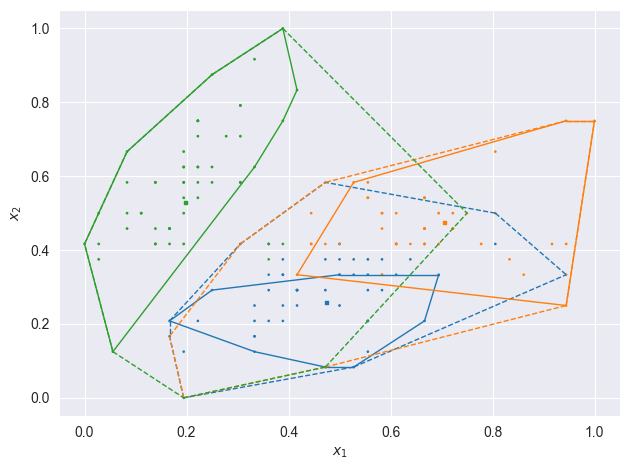

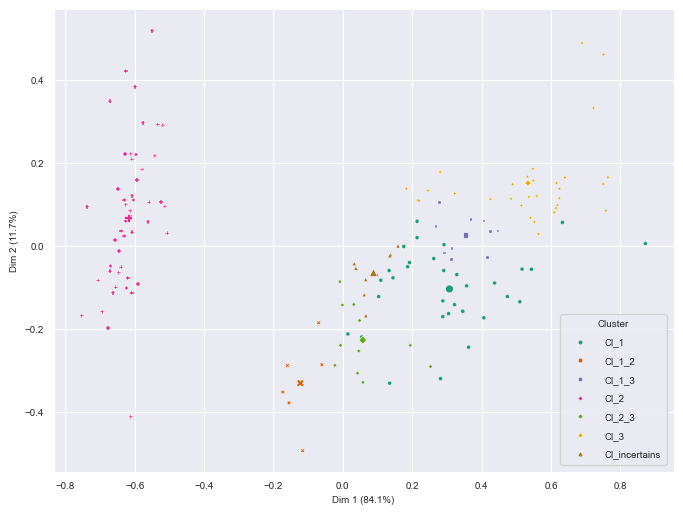

In [29]:
# Plotting PCA 
ev_plot(model, X=X)
ev_pcaplot(data=X, x=best_model, normalize=False)

In [30]:
for W in top_weights:
    print(f"\n{W}")
     


[[0.16734822 0.50160578 0.17236238 0.15868361]
 [0.13949354 0.0269845  0.57318178 0.26034018]
 [0.27281827 0.30807792 0.2381027  0.18100111]]

[[0.11939984 0.08824966 0.42751279 0.36483771]
 [0.22233001 0.18869782 0.52107491 0.06789726]
 [0.16249964 0.41920159 0.05722376 0.361075  ]]

[[0.33867263 0.44089368 0.124017   0.09641669]
 [0.11928345 0.05530282 0.50674731 0.31866642]
 [0.15510876 0.35357493 0.39548003 0.09583629]]

[[0.13485998 0.12344639 0.48173439 0.25995924]
 [0.05449177 0.16251266 0.53917937 0.2438162 ]
 [0.12186831 0.57565216 0.14025942 0.16222011]]

[[0.31542569 0.27403625 0.15886952 0.25166853]
 [0.07200675 0.18094038 0.23500672 0.51204615]
 [0.30363601 0.07704357 0.41881893 0.20050149]]

[[0.30092549 0.27808935 0.2035958  0.21738936]
 [0.32627841 0.03649437 0.3743252  0.26290202]
 [0.21955865 0.15550784 0.45909754 0.16583596]]

[[0.09968213 0.09240944 0.41082914 0.39707929]
 [0.314558   0.3960352  0.14632603 0.14308078]
 [0.06014947 0.56560839 0.19882937 0.17541277]]

## Non-specificity equation
![test.png](../assets/normlaized-non-specificity.png)